In [478]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def filter_contours(contours, min_size, max_size, image, min_influence):
    filtered_contours = []
    image_area = image.shape[0] * image.shape[1]  # Área total de la imagen

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # Calcula la influencia del contorno
        influence = area / image_area

        # Filtra contornos por tamaño, influencia, y posición
        if min_size <= area <= max_size and influence >= min_influence:
            # Si el contorno está muy cerca de los bordes, lo ignora
            if x > 12 and y > 12 and x + w < image.shape[1] - 12 and y + h < image.shape[0] - 12:
                filtered_contours.append(contour)

    return filtered_contours

def segment_contours(contours, image_shape):
    square_contours = []
    rectangular_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / (image_shape[0] * image_shape[1])
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 0.6 <= aspect_ratio <= 1.5 and area_ratio > 0.06:
            square_contours.append(contour)
        else:
            rectangular_contours.append(contour)
    return square_contours, rectangular_contours

# Function to filter contours that are inside other contours
def filter_inside_contours(contours):
    filtered_contours = []
    for contour in contours:
        parent_contour = None
        for other_contour in contours:
            if contour is not other_contour:
                # Verifica si todos los puntos están dentro del otro contorno
                if all(
                    cv2.pointPolygonTest(other_contour, (int(point[0][0]), int(point[0][1])), False) > 0
                    for point in contour
                ):
                    if parent_contour is None or cv2.contourArea(other_contour) > cv2.contourArea(parent_contour):
                        parent_contour = other_contour
        if parent_contour is None:
            filtered_contours.append(contour)
    return filtered_contours

def separate_contours_by_segments(contours, image_width):
    segments = []
    for i in range(4):
        segments.append([])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image_width // 4)
        segments[segment].append(contour)
    return segments

def get_orientation(contours):
    orientations = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > h:
            orientations.append('horizontal')
            # return 'Horizontal'
        else:
            orientations.append('vertical')
            # return 'Vertical'
    return orientations

def order_contours(segments):
    ordered_segments = []
    for segment in segments:
        if len(segment) <= 1:
            ordered_segments.append(segment)
        elif len(segment) == 2:
            x1, y1, w1, h1 = cv2.boundingRect(segment[0])
            x2, y2, w2, h2 = cv2.boundingRect(segment[1])
            if w1 > h1 and w2 > h2:
                if y1 < y2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
            elif w1 < h1 and w2 < h2:
                if x1 < x2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
        else:
            ordered_segments.append(segment)
    return ordered_segments

def get_area_ratio(contours, image):
    image_area = (image.shape[0] * image.shape[1]) / 4
    area_ratios = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / image_area
        area_ratios.append(round(area_ratio, 3))
    return area_ratios

# Decode segment number given the information of the segments
def decode_number(segment_info):
    segment_number = ''
    for i in range(4):
        # Validar si el segmento tiene la estructura esperada
        if i >= len(segment_info):
            segment_number += 'X'
            continue
        
        num_contours = segment_info[i]['num_contours']
        orientation = segment_info[i]['orientation']
        area_ratios = segment_info[i]['area_ratios']
        area_ratios_relation = segment_info[i]['area_ratios_relation']
        if num_contours == 0:
            segment_number += '0'
        elif num_contours == 1:
            if orientation[0] == 'horizontal':
                segment_number += '8'
            else:
                if area_ratios[0] < 0.15:
                    segment_number += '1'
                else:
                    segment_number += '5'
        elif num_contours == 2:
            if orientation[0] == 'horizontal':
                if area_ratios_relation > 1.2:
                    segment_number += '7'
                elif area_ratios_relation < 0.8:
                    segment_number += '9'
                else:
                    segment_number += '3'
            else:
                if area_ratios_relation > 1.2:
                    segment_number += '6'
                elif area_ratios_relation < 0.8:
                    segment_number += '4'
                else:
                    segment_number += '2'
        else:
            segment_number += 'X'
    return segment_number

def extract_segment_info(segment, image):
    num_contours = len(segment)
    orientations = [
        'horizontal' if cv2.boundingRect(c)[2] > cv2.boundingRect(c)[3] else 'vertical'
        for c in segment
    ]
    area_ratios = get_area_ratio(segment, image)
    if len(segment) == 2:
        area_ratio_relation = round(
            cv2.contourArea(segment[0]) / cv2.contourArea(segment[1]), 3
        )
    else:
        area_ratio_relation = None

    return {
        'num_contours': num_contours,
        'orientation': orientations,
        'area_ratios': area_ratios,
        'area_ratios_relation': area_ratio_relation
    }

segment_info_global = []

def process_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_blur = cv2.GaussianBlur(image_gray, (11, 11), 0)
    image_thresh = cv2.adaptiveThreshold(image_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    image_eroded = cv2.erode(image_thresh, np.ones((3, 3), np.uint8), iterations=1)
    contours, _ = cv2.findContours(image_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and segment contours
    filtered_contours = filter_contours(contours, 200, 25000, image_eroded, 0.01)
    _, rectangular_contours = segment_contours(filtered_contours, image_eroded.shape)
    rectangular_contours = filter_inside_contours(rectangular_contours)

    # Separate and process segments
    segments = separate_contours_by_segments(rectangular_contours, image.shape[1])
    ordered_segments = order_contours(segments)

    # Extraer información de cada segmento
    segment_info = [extract_segment_info(segments, image) for segments in ordered_segments]

    number_decode = decode_number(segment_info)
    
    # Almacenar segment_info de esta imagen en la matriz global
    segment_info_global.append(segment_info)

    return number_decode


### Matriz de confusión

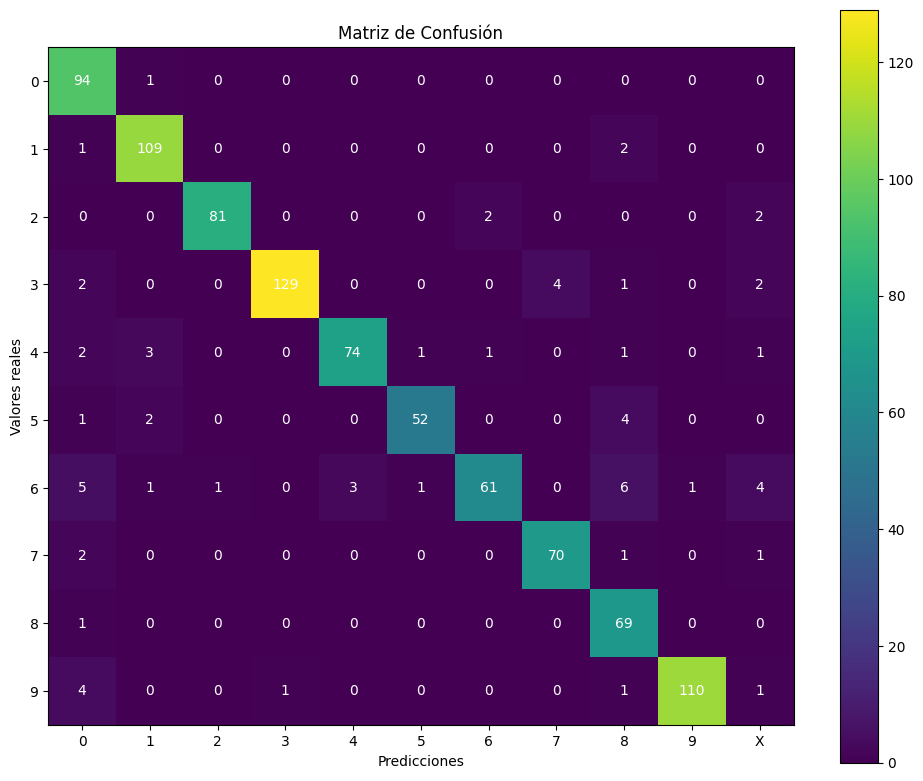

In [479]:
# Inicializar la matriz de confusión con 11 clases (0-9 y X)
num_clases = 11  # Clases 0-9 y "X"
matriz_confusion = np.zeros((10, num_clases), dtype=int)

# Lista para almacenar las imágenes mal predichas
imagenes_mal_predichas = []

# Procesar las imágenes en el directorio
folder_path = "Processed Images"
# Ruta de la carpeta de destino para las imágenes mal predichas
carpeta_destino = "ImagenesProblematicas"
os.makedirs(carpeta_destino, exist_ok=True)  # Crear la carpeta si no existe

archivos = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

for file_name in archivos:
    # Leer la imagen
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    # Extraer los primeros 4 dígitos del nombre del archivo
    digitos_imagen = file_name[:4]  # Los primeros 4 dígitos del nombre
    digitos_imagen_array = [int(d) for d in digitos_imagen]

    # Predecir los 4 dígitos utilizando tu función `process_image`
    codigo_segmentos = process_image(image_path)

    # Validar que el resultado tenga exactamente 4 caracteres
    if len(codigo_segmentos) < 4:
        codigo_segmentos += "X" * (4 - len(codigo_segmentos))  # Rellenar con 'X' si es necesario
    codigo_segmentos_array = []
    for char in codigo_segmentos:
        if char.isdigit():
            codigo_segmentos_array.append(int(char))
        else:
            codigo_segmentos_array.append(10)  # Asignar 'X' como clase 11

    # Añadir `valor_real` a cada segmento en `segment_info_global`
    for i, segment in enumerate(segment_info_global[-1]):  # Usar la última entrada añadida por `process_image`
        if i < len(digitos_imagen_array):  # Validar índices
            segment["valor_real"] = digitos_imagen_array[i]
        else:
            segment["valor_real"] = None  # Si falta información, asignar None

    # Comparar los códigos
    for j in range(4):  # Comparar los 4 dígitos
        fila = digitos_imagen_array[j]
        columna = codigo_segmentos_array[j]
        matriz_confusion[fila, columna] += 1

        # Si no coinciden, agregar el nombre de la imagen y la posición del error
        if fila != columna:
            imagenes_mal_predichas.append({
                "archivo": file_name,
                "posición": j + 1,
                "real": fila,
                "predicción": columna
            })
    # Si la imagen está en las mal predichas, moverla a la carpeta problemática
    if any(item["archivo"] == file_name for item in imagenes_mal_predichas):
        destino_imagen = os.path.join(carpeta_destino, file_name)


# Mostrar las imágenes mal predichas
# print("Imágenes mal predichas:")
# for error in imagenes_mal_predichas:
#     real_label = str(error["real"]) if error["real"] < 10 else "X"
#     pred_label = str(error["predicción"]) if error["predicción"] < 10 else "X"
#     print(f"Archivo: {error['archivo']}, Posición: {error['posición']}, Real: {real_label}, Predicción: {pred_label}")
    
# Crear un heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(matriz_confusion, interpolation='nearest', cmap='viridis')
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")

# Etiquetas de clases
x_labels = [str(i) for i in range(10)] + ["X"]
y_labels = [str(i) for i in range(10)]
plt.xticks(np.arange(num_clases), x_labels)
plt.yticks(np.arange(10), y_labels)

# Mostrar los valores en la matriz
for i in range(10):
    for j in range(num_clases):
        plt.text(j, i, str(matriz_confusion[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

### Tasa de acierto del clasificador

In [480]:
# Calcular accuracy
correctos = np.sum(np.diag(matriz_confusion[:, :10]))  # Valores correctos en las primeras 10 columnas
total = np.sum(matriz_confusion)  # Total de predicciones
accuracy = correctos / total if total > 0 else 0

# Calcular el sumatorio de todos los números analizados
total_numeros_analizados = np.sum(matriz_confusion)
aciertos = np.sum(np.diagonal(matriz_confusion))

# Mostrar el sumatorio de los aciertos
print(f"Total de aciertos (diagonal): {aciertos}")

# Mostrar el sumatorio
print(f"Total de números analizados: {total_numeros_analizados}")

# Mostrar accuracy
print(f"Tasa de acierto del clasificador: {accuracy * 100:.2f}%")

Total de aciertos (diagonal): 849
Total de números analizados: 916
Tasa de acierto del clasificador: 92.69%


### Confusiones

In [481]:
# Función para obtener las confusiones más frecuentes
def obtener_confusiones(matriz_confusion):
    confusiones = []
    for i in range(matriz_confusion.shape[0]):  # Recorrer filas (valores reales)
        for j in range(matriz_confusion.shape[1]):  # Recorrer columnas (predicciones)
            if i != j and matriz_confusion[i, j] > 0:  # Evitar la diagonal principal
                confusiones.append(((i, j), matriz_confusion[i, j]))
    
    # Ordenar por la cantidad de confusiones en orden descendente
    confusiones.sort(key=lambda x: x[1], reverse=True)
    return confusiones

# Obtener las confusiones más frecuentes
confusiones_mas_frecuentes = obtener_confusiones(matriz_confusion)

# Imprimir las confusiones
print("Confusiones más frecuentes:")
for (real, pred), cantidad in confusiones_mas_frecuentes:
    real_label = str(real) if real < 10 else "X"
    pred_label = str(pred) if pred < 10 else "X"
    print(f"Real: {real_label}, Predicción: {pred_label}, Cantidad: {cantidad}")

Confusiones más frecuentes:
Real: 6, Predicción: 8, Cantidad: 6
Real: 6, Predicción: 0, Cantidad: 5
Real: 3, Predicción: 7, Cantidad: 4
Real: 5, Predicción: 8, Cantidad: 4
Real: 6, Predicción: X, Cantidad: 4
Real: 9, Predicción: 0, Cantidad: 4
Real: 4, Predicción: 1, Cantidad: 3
Real: 6, Predicción: 4, Cantidad: 3
Real: 1, Predicción: 8, Cantidad: 2
Real: 2, Predicción: 6, Cantidad: 2
Real: 2, Predicción: X, Cantidad: 2
Real: 3, Predicción: 0, Cantidad: 2
Real: 3, Predicción: X, Cantidad: 2
Real: 4, Predicción: 0, Cantidad: 2
Real: 5, Predicción: 1, Cantidad: 2
Real: 7, Predicción: 0, Cantidad: 2
Real: 0, Predicción: 1, Cantidad: 1
Real: 1, Predicción: 0, Cantidad: 1
Real: 3, Predicción: 8, Cantidad: 1
Real: 4, Predicción: 5, Cantidad: 1
Real: 4, Predicción: 6, Cantidad: 1
Real: 4, Predicción: 8, Cantidad: 1
Real: 4, Predicción: X, Cantidad: 1
Real: 5, Predicción: 0, Cantidad: 1
Real: 6, Predicción: 1, Cantidad: 1
Real: 6, Predicción: 2, Cantidad: 1
Real: 6, Predicción: 5, Cantidad: 1


### Diagrama de dispersión de los valores reales y sus predicciones

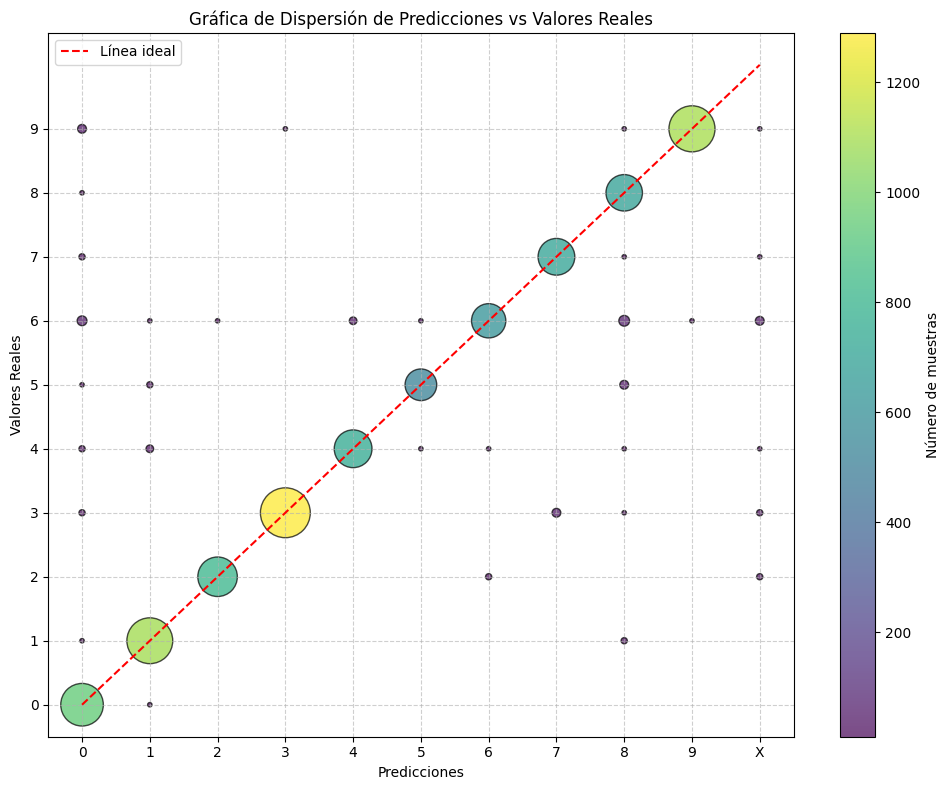

In [482]:
# Crear los datos para la gráfica de dispersión
x = []
y = []
sizes = []

# Recorrer la matriz de confusión
for i in range(10):  # Valores reales (eje y)
    for j in range(num_clases):  # Predicciones (eje x)
        if matriz_confusion[i, j] > 0:  # Solo considerar puntos con datos
            x.append(j)  # Predicción
            y.append(i)  # Valor real
            sizes.append(matriz_confusion[i, j] * 10)  # Escalar el tamaño

# Crear la figura
plt.figure(figsize=(10, 8))

# Dibujar la línea ideal (y = x)
plt.plot(range(11), range(11), linestyle='--', color='red', label='Línea ideal')

# Crear la gráfica de dispersión
scatter = plt.scatter(x, y, s=sizes, c=sizes, cmap='viridis', alpha=0.7, edgecolor='k')

# Etiquetas y leyenda
plt.colorbar(scatter, label='Número de muestras')
plt.title('Gráfica de Dispersión de Predicciones vs Valores Reales')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.xticks(range(11), [str(i) for i in range(10)] + ["X"])
plt.yticks(range(10), [str(i) for i in range(10)])
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Convertir características a un Dataframe

In [483]:
# Extraer los nombres de archivo de las imágenes mal predichas
imagenes_mal_predichas_nombres = [item["archivo"] for item in imagenes_mal_predichas]

# Convertir los resultados en un DataFrame
data = []
new_segment_info_global = []

for image_idx, segment_info in enumerate(segment_info_global):
    file_name = archivos[image_idx]
    
    # Si la imagen está en las mal predichas, no incluirla en el DataFrame
    if file_name in imagenes_mal_predichas_nombres:
        continue  # Saltar la iteración y no añadir esta imagen al DataFrame
    
    for segment_idx, segment in enumerate(segment_info):
        razones_area = segment.get("area_ratios", [])
        
        # Si no hay razones de área, poner 'None'
        razones_area_str = ", ".join(map(str, razones_area)) if razones_area else None
        
        row = {
            "Imagen": file_name,
            "Segmento": segment_idx + 1,
            "Valor Real": segment.get("valor_real", None),
            "Num Contornos": segment.get("num_contours", None),
            "Orientación": segment["orientation"][0] if segment["orientation"] else None,
            "Relación Área": segment.get("area_ratios_relation", None),
            "Razones de Área": razones_area_str,
        }
        data.append(row)

        # Añadir los segmentos no mal predichos a la nueva lista `new_segment_info_global`
    if file_name not in imagenes_mal_predichas_nombres:
        new_segment_info_global.append(segment_info)

# Crear el DataFrame
df = pd.DataFrame(data)
df = df.fillna("N/A")  # Rellenar con "N/A" en lugar de None

# Guardar el DataFrame en un archivo Excel
df.to_excel("resultados_segmentos.xlsx", index=False)

# Visualizar bonito en Jupyter Notebook o IPython
from IPython.display import display
display(df)

,Imagen,Segmento,Valor Real,Num Contornos,Orientación,Relación Área,Razones de Área
0,0000_1_04_9_extracted_1.jpg,1,0,0,N/A,N/A,N/A
1,0000_1_04_9_extracted_1.jpg,2,0,0,N/A,N/A,N/A
2,0000_1_04_9_extracted_1.jpg,3,0,0,N/A,N/A,N/A
3,0000_1_04_9_extracted_1.jpg,4,0,0,N/A,N/A,N/A
4,0018 (2).jpg,1,0,0,N/A,N/A,N/A
...,...,...,...,...,...,...,...
751,9999_1_04_16_extracted_1.jpg,4,9,2,horizontal,0.549,"0.115, 0.209"
752,9999_1_04_17_extracted_1.jpg,1,9,2,horizontal,0.551,"0.108, 0.196"
753,9999_1_04_17_extracted_1.jpg,2,9,2,horizontal,0.558,"0.111, 0.199"
754,9999_1_04_17_extracted_1.jpg,3,9,2,horizontal,0.551,"0.111, 0.201"


### Diagrama dispersión orientación vs area_ratios_relation para segmentos con 2 contornos

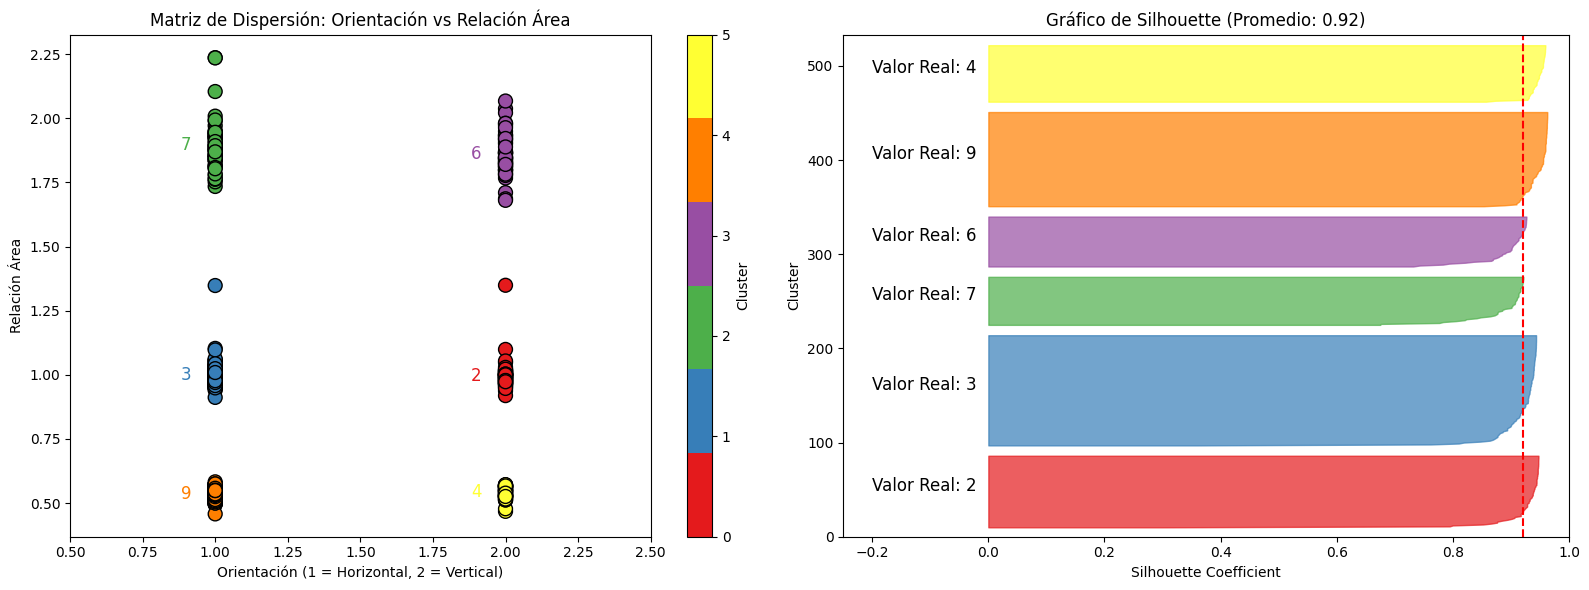

In [484]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.colors import ListedColormap

# Crear listas para almacenar las orientaciones, relaciones de área y valores reales
orientaciones = []
relaciones_area = []
valores_reales = []

# Extraer los datos
for image_idx, segment_info in enumerate(new_segment_info_global):
    for segment_idx, segment in enumerate(segment_info):
        # Obtener la orientación
        orientacion = segment["orientation"][0] if segment["orientation"] else None
        
        # Solo procesar segmentos con dos contornos 
        if segment.get("num_contours", 0) == 2:
            relacion_area = segment.get("area_ratios_relation", None)
        
            # Obtener el valor real
            valor_real = segment.get("valor_real", None)
            
            # Si todos los datos son válidos, agregar a las listas
            if orientacion is not None and relacion_area is not None and valor_real is not None:
                orientaciones.append(orientacion)
                relaciones_area.append(relacion_area)
                valores_reales.append(valor_real)

# Convertir a arrays de numpy para un manejo más fácil
orientaciones = np.array(orientaciones)
relaciones_area = np.array(relaciones_area)
valores_reales = np.array(valores_reales)

# Convertir las orientaciones a valores numéricos (1 para 'horizontal', 2 para 'vertical')
orientaciones_num = np.array([1 if orientacion == 'horizontal' else 2 for orientacion in orientaciones])

# Aplicar KMeans al clustering en función de las orientaciones numéricas y relaciones de área
kmeans = KMeans(n_clusters=len(np.unique(valores_reales)), random_state=42)
clusters = kmeans.fit_predict(np.column_stack((orientaciones_num, relaciones_area)))

# Crear un mapa de colores basado en los clusters
cmap_clusters = ListedColormap(sns.color_palette("Set1", n_colors=len(np.unique(clusters))))

# Crear un diccionario para mapear cada clúster a un valor_real
cluster_to_value_real = {}
for cluster_id in np.unique(clusters):
    # Obtener el valor real más común dentro de cada clúster
    value_real_for_cluster = np.unique(valores_reales[clusters == cluster_id])
    cluster_to_value_real[cluster_id] = value_real_for_cluster[0]  # Suponiendo que cada clúster tiene un único valor real

# Crear la figura y los ejes para ambos gráficos (dispersión y silhouette)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de dispersión con los clusters coloreados
scatter = ax1.scatter(orientaciones_num, relaciones_area, c=clusters, cmap=cmap_clusters, s=100, edgecolors="k")
ax1.set_xlabel("Orientación (1 = Horizontal, 2 = Vertical)")
ax1.set_ylabel("Relación Área")
ax1.set_title("Matriz de Dispersión: Orientación vs Relación Área")
ax1.set_xlim(0.5, 2.5)  # Limitar el eje X de 0.5 a 2.5
fig.colorbar(scatter, ax=ax1, label="Cluster")

# Añadir los valores reales como etiquetas a la izquierda de cada cluster
for cluster_id, value_real in cluster_to_value_real.items():
    ax1.text(np.mean(orientaciones_num[clusters == cluster_id]) - 0.1,  # Desplazamos el texto a la izquierda
             np.mean(relaciones_area[clusters == cluster_id]), 
             str(value_real), color=cmap_clusters(cluster_id), 
             fontsize=12, ha='center', va='center')

# Calcular la Silhouette para los clusters
silhouette_vals = silhouette_samples(np.column_stack((orientaciones_num, relaciones_area)), clusters)
silhouette_avg = silhouette_score(np.column_stack((orientaciones_num, relaciones_area)), clusters)

# Gráfico de Silhouette
ax2.set_xlim([-0.25, 1])  # Cambiar el límite del eje X para que vaya de -0.25 a 1
ax2.set_ylim([0, len(orientaciones) + (len(np.unique(clusters)) + 1) * 10])

y_lower = 10
for i in np.unique(clusters):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()

    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster

    ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=cmap_clusters(i), edgecolor=cmap_clusters(i), alpha=0.7)
    ax2.text(-0.20, (y_lower + y_upper) / 2, f"Valor Real: {cluster_to_value_real[i]}", color='black', fontsize=12)
    
    y_lower = y_upper + 10

ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.set_xlabel("Silhouette Coefficient")
ax2.set_ylabel("Cluster")
ax2.set_title(f"Gráfico de Silhouette (Promedio: {silhouette_avg:.2f})")

plt.tight_layout()
plt.show()


C:\Users\paufe\AppData\Local\Temp\ipykernel_20004\2565159794.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Relación Área', data=data, palette="Set1")


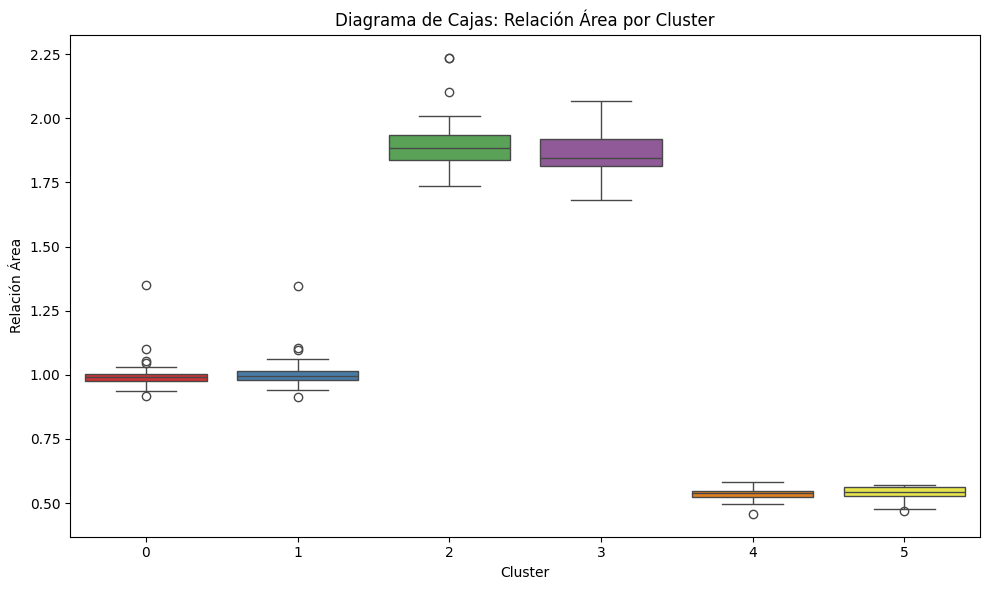

In [485]:
import pandas as pd

# Si 'relaciones_area' es una lista de listas, podemos tomar el promedio de cada lista
relaciones_area_promedio = [np.mean(area) if isinstance(area, (list, np.ndarray)) else area 
                            for area in relaciones_area]

# Crear un DataFrame con las relaciones de área promedio y los clusters
data = pd.DataFrame({
    'Relación Área': relaciones_area_promedio,
    'Cluster': clusters
})

# Crear el diagrama de cajas (boxplot) agrupado por clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Relación Área', data=data, palette="Set1")

# Añadir título y etiquetas
plt.title("Diagrama de Cajas: Relación Área por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Relación Área")

plt.tight_layout()
plt.show()


### Diagrama dispersión orientación vs area_ratios para segmentos con 1 contorno

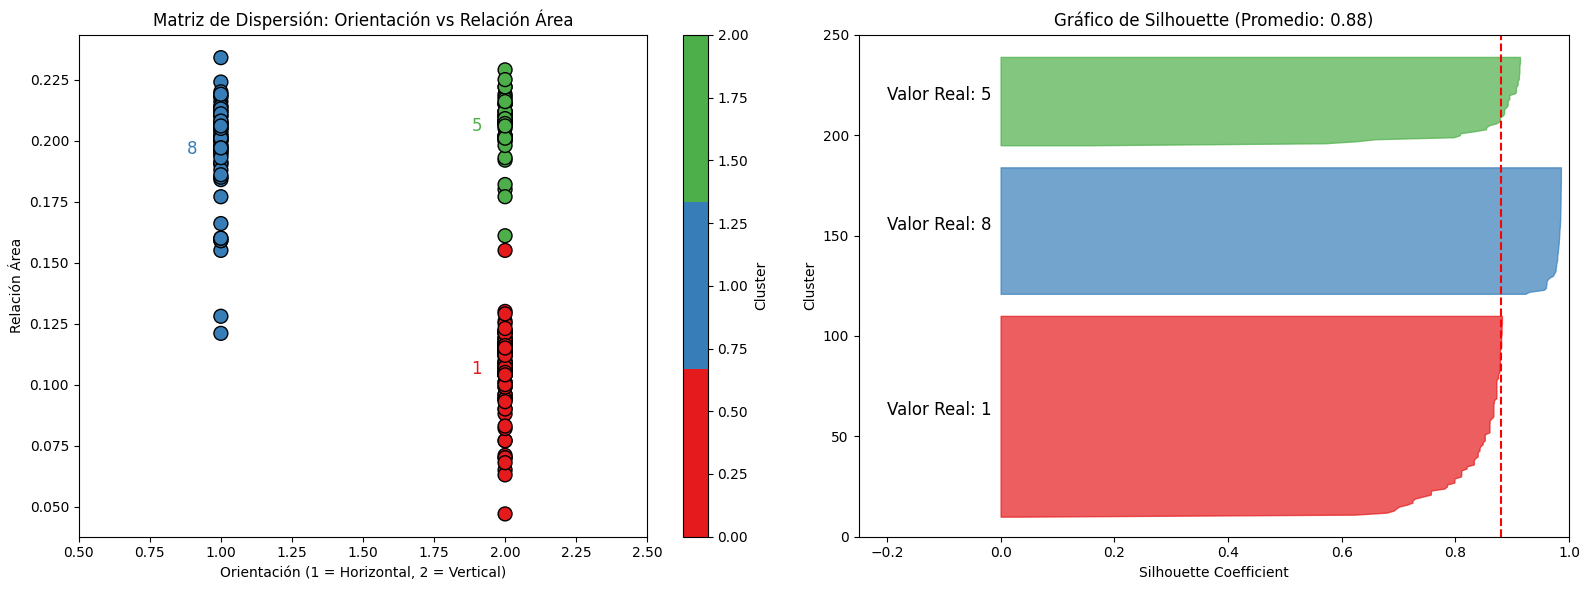

In [486]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.colors import ListedColormap

# Crear listas para almacenar las orientaciones, relaciones de área y valores reales
orientaciones = []
relaciones_area = []
valores_reales = []

# Extraer los datos
for image_idx, segment_info in enumerate(new_segment_info_global):
    for segment_idx, segment in enumerate(segment_info):
        # Obtener la orientación
        orientacion = segment["orientation"][0] if segment["orientation"] else None
        
        # Solo procesar segmentos con un solo contorno
        if segment.get("num_contours", 0) == 1:
            relacion_area = segment.get("area_ratios", None)
        
            # Obtener el valor real
            valor_real = segment.get("valor_real", None)
            
            # Si todos los datos son válidos, agregar a las listas
            if orientacion is not None and relacion_area is not None and valor_real is not None:
                orientaciones.append(orientacion)
                relaciones_area.append(relacion_area)
                valores_reales.append(valor_real)

# Convertir a arrays de numpy para un manejo más fácil
orientaciones = np.array(orientaciones)
relaciones_area = np.array(relaciones_area)
valores_reales = np.array(valores_reales)

# Convertir las orientaciones a valores numéricos (1 para 'horizontal', 2 para 'vertical')
orientaciones_num = np.array([1 if orientacion == 'horizontal' else 2 for orientacion in orientaciones])

# Aplicar KMeans al clustering en función de las orientaciones numéricas y relaciones de área
kmeans = KMeans(n_clusters=len(np.unique(valores_reales)), random_state=42)
clusters = kmeans.fit_predict(np.column_stack((orientaciones_num, relaciones_area)))

# Crear un mapa de colores basado en los clusters
cmap_clusters = ListedColormap(sns.color_palette("Set1", n_colors=len(np.unique(clusters))))

# Crear un diccionario para mapear cada clúster a un valor_real
cluster_to_value_real = {}
for cluster_id in np.unique(clusters):
    # Obtener el valor real más común dentro de cada clúster
    value_real_for_cluster = np.unique(valores_reales[clusters == cluster_id])
    cluster_to_value_real[cluster_id] = value_real_for_cluster[0]  # Suponiendo que cada clúster tiene un único valor real

# Crear la figura y los ejes para ambos gráficos (dispersión y silhouette)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de dispersión con los clusters coloreados
scatter = ax1.scatter(orientaciones_num, relaciones_area, c=clusters, cmap=cmap_clusters, s=100, edgecolors="k")
ax1.set_xlabel("Orientación (1 = Horizontal, 2 = Vertical)")
ax1.set_ylabel("Relación Área")
ax1.set_title("Matriz de Dispersión: Orientación vs Relación Área")
ax1.set_xlim(0.5, 2.5)  # Limitar el eje X de 0.5 a 2.5
fig.colorbar(scatter, ax=ax1, label="Cluster")

# Añadir los valores reales como etiquetas a la izquierda de cada cluster
for cluster_id, value_real in cluster_to_value_real.items():
    ax1.text(np.mean(orientaciones_num[clusters == cluster_id]) - 0.1,  # Desplazamos el texto a la izquierda
             np.mean(relaciones_area[clusters == cluster_id]), 
             str(value_real), color=cmap_clusters(cluster_id), 
             fontsize=12, ha='center', va='center')

# Calcular la Silhouette para los clusters
silhouette_vals = silhouette_samples(np.column_stack((orientaciones_num, relaciones_area)), clusters)
silhouette_avg = silhouette_score(np.column_stack((orientaciones_num, relaciones_area)), clusters)

# Gráfico de Silhouette
ax2.set_xlim([-0.25, 1])  # Cambiar el límite del eje X para que vaya de -0.25 a 1
ax2.set_ylim([0, len(orientaciones) + (len(np.unique(clusters)) + 1) * 10])

y_lower = 10
for i in np.unique(clusters):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()

    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster

    ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=cmap_clusters(i), edgecolor=cmap_clusters(i), alpha=0.7)
    ax2.text(-0.20, (y_lower + y_upper) / 2, f"Valor Real: {cluster_to_value_real[i]}", color='black', fontsize=12)
    
    y_lower = y_upper + 10

ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.set_xlabel("Silhouette Coefficient")
ax2.set_ylabel("Cluster")
ax2.set_title(f"Gráfico de Silhouette (Promedio: {silhouette_avg:.2f})")

plt.tight_layout()
plt.show()


### Diagrama de cajas

C:\Users\paufe\AppData\Local\Temp\ipykernel_20004\2565159794.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Relación Área', data=data, palette="Set1")


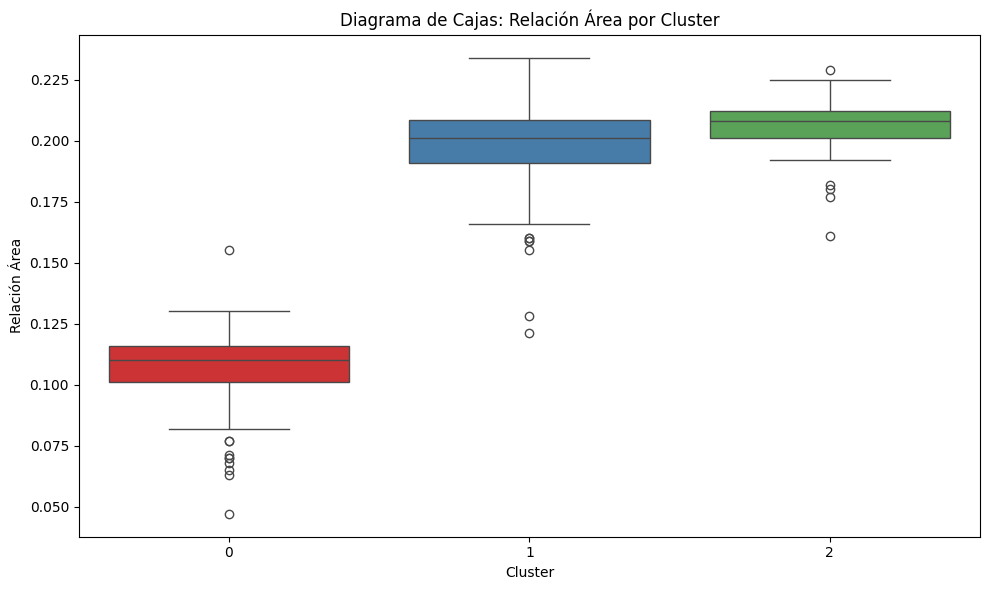

In [487]:
import pandas as pd

# Si 'relaciones_area' es una lista de listas, podemos tomar el promedio de cada lista
relaciones_area_promedio = [np.mean(area) if isinstance(area, (list, np.ndarray)) else area 
                            for area in relaciones_area]

# Crear un DataFrame con las relaciones de área promedio y los clusters
data = pd.DataFrame({
    'Relación Área': relaciones_area_promedio,
    'Cluster': clusters
})

# Crear el diagrama de cajas (boxplot) agrupado por clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Relación Área', data=data, palette="Set1")

# Añadir título y etiquetas
plt.title("Diagrama de Cajas: Relación Área por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Relación Área")

plt.tight_layout()
plt.show()


### Matriz de correlación de las características

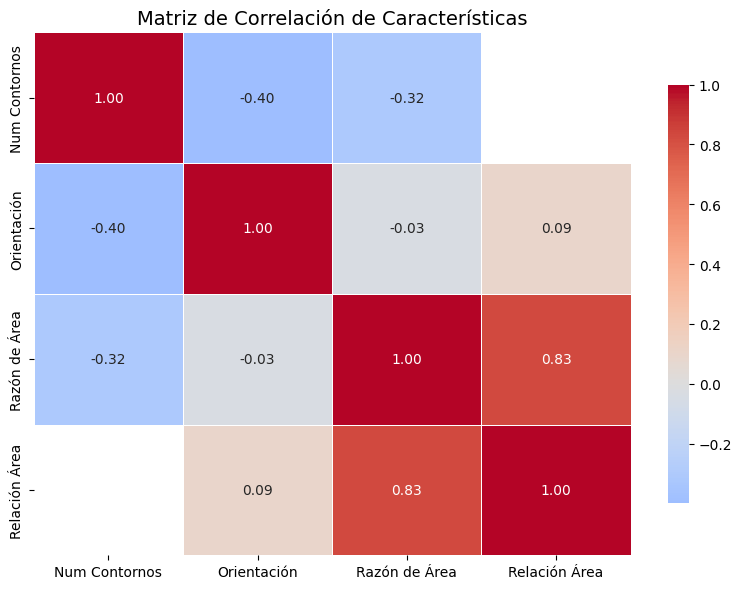

In [488]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir 'Orientación' a valores numéricos (0 para 'horizontal' y 1 para 'vertical')
df["Orientación"] = df["Orientación"].apply(lambda x: 0 if x == "horizontal" else 1)

# Convertir 'Relación Área' a numérico si es necesario (si ya lo es, este paso se puede omitir)
df["Relación Área"] = pd.to_numeric(df["Relación Área"], errors="coerce")

# Convertir 'Razones de Área' en listas de valores y extraer la primera relación de área (si es aplicable)
# Si 'Razones de Área' es una cadena con valores numéricos, debemos extraer el primer valor
df["Razón de Área"] = df["Razones de Área"].apply(lambda x: float(x.split(',')[0]) if x != "N/A" else None)

# Filtramos solo las columnas numéricas para la matriz de correlación
df_numeric = df[["Num Contornos", "Orientación", "Razón de Área", "Relación Área"]]

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": 0.8})

# Título del gráfico
plt.title("Matriz de Correlación de Características", fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()
